In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
import seaborn as sns
from joblib import Parallel, delayed
from scipy.stats import multivariate_normal

#### Simple Demonstration of Online Learning

In [135]:
def online_sample_from_task(d=2):
    mu = np.array([1, 1])
    Y = np.random.binomial(1, 0.5)
    X = np.random.multivariate_normal((-1)**(Y+1)*mu, np.eye(d))
    return X, 2*Y-1

def batch_sample_from_task(n, d=2):
    mu = np.array([1, 1])
    X = np.concatenate((np.random.multivariate_normal((-1)*mu, np.eye(d), size=n // 2),
                        np.random.multivariate_normal(mu, np.eye(d), size=n // 2)))
    Y = np.concatenate((-np.ones(n // 2), np.ones(n // 2)))
    return X, Y

In [136]:
T = 500
n_test = 500

w = np.array([1, 0]) # initialize
X, Y = batch_sample_from_task(n_test)
error = []
for t in range(1, T):
    x, y = online_sample_from_task()
    lr = 0.01
    w = w + lr * x * y
    w = w / np.linalg.norm(w)
    
    Y_hat = np.sign(X @ w)
    error.append(np.mean(Y != Y_hat))

Text(0.5, 0, 'Time')

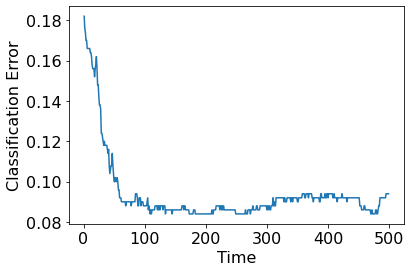

In [137]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, 500), error)
ax.set_ylabel("Classification Error")
ax.set_xlabel("Time")

#### Online Learning vs Alternating Task Sequence

In [15]:
def online_sample_from_task_sequence(t, N=20, d=2):
    if (t // N) % 2 == 0:
        mu = np.array([1, 1])
    else:
        mu = np.array([-1, -1])    
    Y = np.random.binomial(1, 0.5)
    X = np.random.multivariate_normal((-1)**(Y+1)*mu, np.eye(d))
    return X, 2*Y-1

def batch_sample_from_task_sequence(n, t, N=20, d=2, seed=1996):
    if (t // N) % 2 == 0:
        mu = np.array([1, 1])
    else:
        mu = np.array([-1, -1])    
    X = np.concatenate((np.random.multivariate_normal((-1)*mu, np.eye(d), size=n // 2),
                        np.random.multivariate_normal(mu, np.eye(d), size=n // 2)))
    Y = np.concatenate((-np.ones(n // 2), np.ones(n // 2)))
    return X, Y

In [16]:
N = 500
T = 5000
n_test = 100
n_reps = 20

def ogd_loop():
    w = np.random.randn(2,)
    w = w / np.linalg.norm(w)
    ogd_error = []
    for t in range(1, T):
        x, y = online_sample_from_task_sequence(t, N)
        
        X_test, Y_test = batch_sample_from_task_sequence(n_test, t, N)
        Y_hat = np.sign(X_test @ w)
        ogd_error.append(np.mean(Y_test != Y_hat))

        # online gradient descent algorithm
        lr = 0.01
        w = w + lr * x * y
        w = w / np.linalg.norm(w)
    return ogd_error

ogd_error_reps = np.array(Parallel(n_jobs=-1)(delayed(ogd_loop)() for i in range(n_reps)))
ogd_error = ogd_error_reps.mean(axis=0)
c_ogd = ogd_error_reps.std(axis=0)/np.sqrt(n_reps)*1.96

In [17]:
def ftl_loop():
    w = np.random.randn(2,)
    w = w / np.linalg.norm(w)
    X_train = np.empty((0, 2))
    Y_train = np.empty((0,))
    ftl_error = []
    for t in range(1, T):
        x, y = online_sample_from_task_sequence(t, N)
        
        X_test, Y_test = batch_sample_from_task_sequence(n_test, t, N)
        Y_hat = np.sign(X_test @ w)
        ftl_error.append(np.mean(Y_test != Y_hat))

        # follow the leader algorithm
        X_train = np.concatenate((X_train, x.reshape(1, 2)), axis=0)
        Y_train = np.append(Y_train, y)
        if len(Y_train[Y_train==-1]) >=5 and len(Y_train[Y_train==-1]) >=5:
            m_0 = np.nanmean(X_train[Y_train==-1], axis=0)
            m_1 = np.nanmean(X_train[Y_train==1], axis=0)
            S_0 = np.cov(np.array(X_train[Y_train==-1]),rowvar=False)
            S_1 = np.cov(np.array(X_train[Y_train==1]), rowvar=False)
            try:
                w = np.linalg.pinv(S_0 + S_1) @ (m_1 - m_0)
            except LinAlgError:
                S_0 = S_1 = np.eye(2)
                w = np.linalg.pinv(S_0 + S_1) @ (m_1 - m_0)
            w = w / np.linalg.norm(w)
    return ftl_error

ftl_error_reps = np.array(Parallel(n_jobs=-1)(delayed(ftl_loop)() for i in range(n_reps)))
ftl_error = ftl_error_reps.mean(axis=0)
c_ftl = ftl_error_reps.std(axis=0)/np.sqrt(n_reps)*1.96

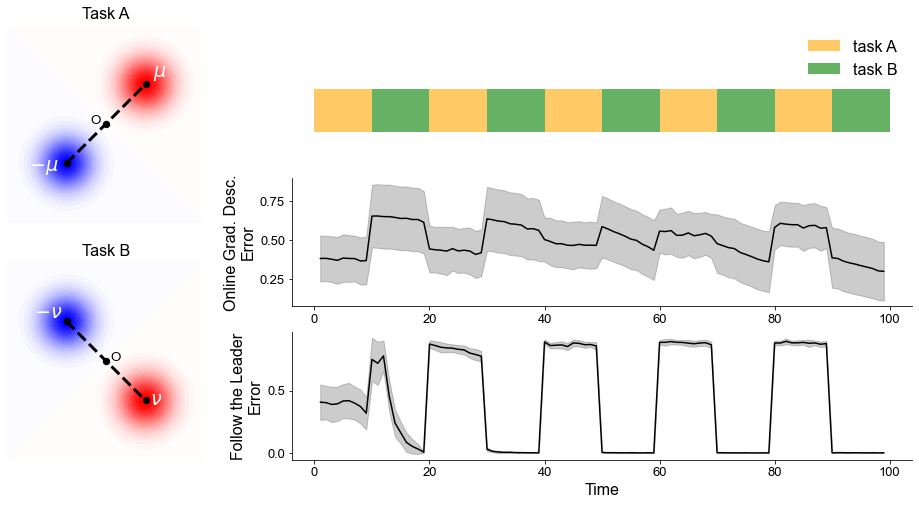

In [5]:
# left = [['left1'], 
#         ['left2'],]
# right = [['right1'],
#          ['right2'],
#          ['right3'],]
# fig, axes = plt.subplot_mosaic([[left, right]], figsize=(20, 8))
# ax = axes['left1']

# x, y = np.mgrid[-3:3:.1, -3:3:.1]
# rv = multivariate_normal([1, 1], 0.20*np.eye(2))
# data = np.dstack((x, y))
# z1 = rv.pdf(data)
# rv = multivariate_normal([-1, -1], 0.20*np.eye(2))
# data = np.dstack((x, y))
# z2 = rv.pdf(data)
# z = z1 - z2
# ax.contourf(x, y, z, cmap='bwr', levels=100, alpha=1, extend='both')

# # c1 = Circle((1, 1), 1, fc="g", alpha=0.6)
# # c2 = Circle((-1, -1), 1, fc="r", alpha=0.6)
# # patches = [c1, c2]
# # for patch in patches:
# #     ax.add_artist(patch)

# ax.plot([-1, 1], [-1, 1], c='k', lw=3, ls="dashed")
# ax.scatter([0], [0], c='k', s=40)
# ax.scatter([1], [1], c='k', s=40)
# ax.scatter([-1], [-1], c='k', s=40)
# ax.text(-0.4, 0, "O", size='small')
# ax.text(-1.2, -1.2, r"$-\mu$", size='large', ha='right', color='white')
# ax.text(1.2, 1.2, r"$\mu$", size='large', ha='left', color='white')
# ax.set_xlim([-2.5, 2.5])
# ax.set_ylim([-2.5, 2.5])
# ax.set_aspect("equal")
# ax.set_title("Task A", fontsize=16)
# ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
# # ax.legend(["Y = 1", "Y = -1"], fontsize=13, frameon=False, loc=2)
# ax.set_xticks([])
# ax.set_yticks([])

# ax = axes['left2']

# x, y = np.mgrid[-3:3:.1, -3:3:.1]
# rv = multivariate_normal([1, -1], 0.20*np.eye(2))
# data = np.dstack((x, y))
# z1 = rv.pdf(data)
# rv = multivariate_normal([-1, 1], 0.20*np.eye(2))
# data = np.dstack((x, y))
# z2 = rv.pdf(data)
# z = z1 - z2
# ax.contourf(x, y, z, cmap='bwr', levels=100, alpha=1, extend='both')

# # c1 = Circle((-1, 1), 1, fc="g", alpha=0.6)
# # c2 = Circle((1, -1), 1, fc="r", alpha=0.6)
# # patches = [c1, c2]
# # for patch in patches:
# #     ax.add_artist(patch)

# ax.plot([-1, 1], [1, -1], c='k', lw=3, ls="dashed")
# ax.scatter([0], [0], c='k', s=40)
# ax.scatter([-1], [1], c='k', s=40)
# ax.scatter([1], [-1], c='k', s=40)
# ax.text(0.1, 0, "O", size='small')
# ax.text(-1.1, 1.1, r"$-\nu$", size='large', ha='right', color='white')
# ax.text(1.1, -1.1, r"$\nu$", size='large', ha='left', color='white')
# ax.set_xlim([-2.5, 2.5])
# ax.set_ylim([-2.5, 2.5])
# ax.set_aspect("equal")
# ax.set_title("Task B", fontsize=16)
# ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
# ax.set_xticks([])
# ax.set_yticks([])

# # ax.plot([-1, 1], [-1, 1], c='k', lw=3, ls="dashed")
# # ax.scatter([0], [0], c='k', s=40)
# # ax.scatter([1], [1], c='k', s=40)
# # ax.scatter([-1], [-1], c='k', s=40)
# # ax.text(-0.4, 0, "O", size='small')
# # ax.text(-1.2, -1.2, r"$-\mu$", size='large', ha='right', color='white')
# # ax.text(1.2, 1.2, r"$\mu$", size='large', ha='left', color='white')
# # ax.set_xlim([-2.5, 2.5])
# # ax.set_ylim([-2.5, 2.5])
# # ax.set_aspect("equal")
# # ax.set_title("Task A", fontsize=16)
# # ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
# # # ax.legend(["Y = 1", "Y = -1"], fontsize=13, frameon=False, loc=2)
# # ax.set_xticks([])
# # ax.set_yticks([])

# ax = axes['right1']
# xlocs = np.arange(0, T, N)
# for i, x in enumerate(xlocs):
#     if i % 2 == 0:
#         ax.add_artist(Rectangle((x, 0), N, 2, fc='orange', alpha=0.6))
#     else:
#         ax.add_artist(Rectangle((x, 0), N, 2, fc='g', alpha=0.6))
# ax.set_ylim([-1, 5])
# ax.legend(["task A", "task B"], loc=1, frameon=False, fontsize=16)
# ax.axis('off')

# sns.set_style("white")
# sns.set_style("ticks")
# sns.set_palette('pastel')

# ax = axes['right2']
# ax.plot(np.arange(1, T), ogd_error, c='k')
# ax.fill_between(np.arange(1, T), ogd_error-c_ogd, ogd_error+c_ogd, alpha=0.2, color='k')
# ax.set_ylabel("Online Grad. Desc." + "\n" + "Error", fontsize=16)
# ax.spines[['right', 'top']].set_visible(False)
# ax.tick_params(labelsize=13)

# ax = axes['right3']
# ax.plot(np.arange(1, T), ftl_error, c='k')
# ax.fill_between(np.arange(1, T), ftl_error-c_ftl, ftl_error+c_ftl, alpha=0.2, color='k')
# ax.set_ylabel("Follow the Leader" + "\n" + "Error", fontsize=16)
# ax.set_xlabel("Time", fontsize=16)
# ax.spines[['right', 'top']].set_visible(False)
# ax.tick_params(labelsize=13)

# axes['right1'].set_xlim(ax.get_xlim())

# plt.subplots_adjust(wspace=-0.2)
# plt.show()

In [6]:
# fig.savefig("figures/online_seq2.pdf", bbox_inches='tight')

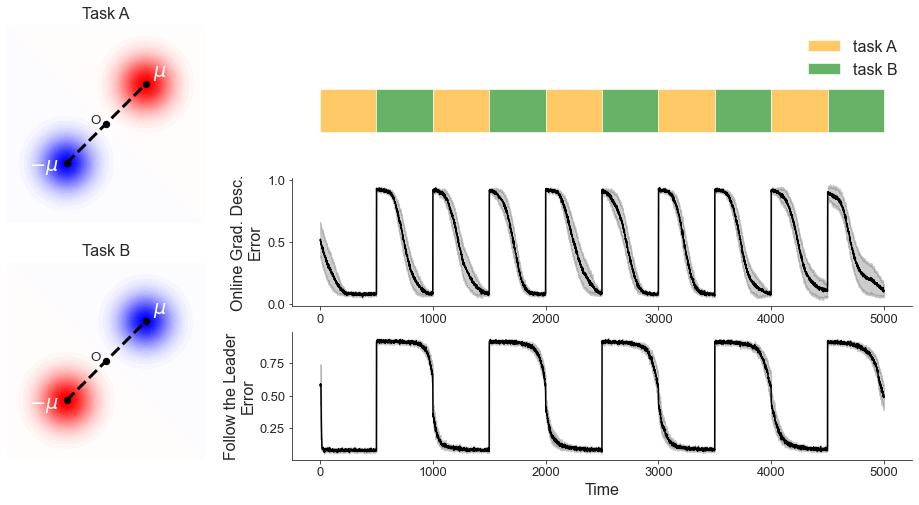

In [18]:
left = [['left1'], 
        ['left2'],]
right = [['right1'],
         ['right2'],
         ['right3'],]
fig, axes = plt.subplot_mosaic([[left, right]], figsize=(20, 8))

ax = axes['left1']

sns.set_palette('pastel')

x, y = np.mgrid[-3:3:.1, -3:3:.1]
rv = multivariate_normal([1, 1], 0.20*np.eye(2))
data = np.dstack((x, y))
z1 = rv.pdf(data)
rv = multivariate_normal([-1, -1], 0.20*np.eye(2))
data = np.dstack((x, y))
z2 = rv.pdf(data)
z = z1 - z2
ax.contourf(x, y, z, cmap='bwr', levels=100, alpha=1, extend='both')

# c1 = Circle((1, 1), 1, fc="g", alpha=0.6)
# c2 = Circle((-1, -1), 1, fc="r", alpha=0.6)
# patches = [c1, c2]
# for patch in patches:
#     ax.add_artist(patch)

ax.plot([-1, 1], [-1, 1], c='k', lw=3, ls="dashed")
ax.scatter([0], [0], c='k', s=40)
ax.scatter([1], [1], c='k', s=40)
ax.scatter([-1], [-1], c='k', s=40)
ax.text(-0.4, 0, "O", size='small')
ax.text(-1.2, -1.2, r"$-\mu$", size='large', ha='right', color='white')
ax.text(1.2, 1.2, r"$\mu$", size='large', ha='left', color='white')
ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-2.5, 2.5])
ax.set_aspect("equal")
ax.set_title("Task A", fontsize=16)
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
# ax.legend(["Y = 1", "Y = -1"], fontsize=13, frameon=False, loc=2)
ax.set_xticks([])
ax.set_yticks([])

ax = axes['left2']

x, y = np.mgrid[-3:3:.1, -3:3:.1]
rv = multivariate_normal([-1, -1], 0.20*np.eye(2))
data = np.dstack((x, y))
z1 = rv.pdf(data)
rv = multivariate_normal([1, 1], 0.20*np.eye(2))
data = np.dstack((x, y))
z2 = rv.pdf(data)
z = z1 - z2
ax.contourf(x, y, z, cmap='bwr', levels=100, alpha=1, extend='both')

# c1 = Circle((1, 1), 1, fc="r", alpha=0.6)
# c2 = Circle((-1, -1), 1, fc="g", alpha=0.6)
# patches = [c1, c2]
# for patch in patches:
#     ax.add_artist(patch)

ax.plot([-1, 1], [-1, 1], c='k', lw=3, ls="dashed")
ax.scatter([0], [0], c='k', s=40)
ax.scatter([1], [1], c='k', s=40)
ax.scatter([-1], [-1], c='k', s=40)
ax.text(-0.4, 0, "O", size='small')
ax.text(-1.2, -1.2, r"$-\mu$", size='large', ha='right', color='white')
ax.text(1.2, 1.2, r"$\mu$", size='large', ha='left', color='white')
ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-2.5, 2.5])
ax.set_aspect("equal")
ax.set_title("Task B", fontsize=16)
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
# ax.legend(["Y = 1", "Y = -1"], fontsize=13, frameon=False, loc=2)
ax.set_xticks([])
ax.set_yticks([])

ax = axes['right1']
xlocs = np.arange(0, T, N)
for i, x in enumerate(xlocs):
    if i % 2 == 0:
        ax.add_artist(Rectangle((x, 0), N, 2, fc='orange', alpha=0.6))
    else:
        ax.add_artist(Rectangle((x, 0), N, 2, fc='g', alpha=0.6))
ax.set_ylim([-1, 5])
ax.legend(["task A", "task B"], loc=1, frameon=False, fontsize=16)
ax.axis('off')

sns.set_style("white")
sns.set_style("ticks")
sns.set_palette('pastel')

ax = axes['right2']
ax.plot(np.arange(1, T), ogd_error, c='k')
ax.fill_between(np.arange(1, T), ogd_error-c_ogd, ogd_error+c_ogd, alpha=0.2, color='k')
ax.set_ylabel("Online Grad. Desc." + "\n" + "Error", fontsize=16)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=13)

ax = axes['right3']
ax.plot(np.arange(1, T), ftl_error, c='k')
ax.fill_between(np.arange(1, T), ftl_error-c_ftl, ftl_error+c_ftl, alpha=0.2, color='k')
ax.set_ylabel("Follow the Leader" + "\n" + "Error", fontsize=16)
ax.set_xlabel("Time", fontsize=16)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=13)

axes['right1'].set_xlim(ax.get_xlim())

plt.subplots_adjust(wspace=-0.2)
plt.show()

In [19]:
fig.savefig("figures/online_seq1.pdf", bbox_inches='tight')

In [11]:
np.save('results/ogd_error.npy', ogd_error)
np.save('results/ftl_error.npy', ftl_error)
np.save('results/ogd_conf.npy', c_ogd)
np.save('results/ftl_conf.npy', c_ftl)

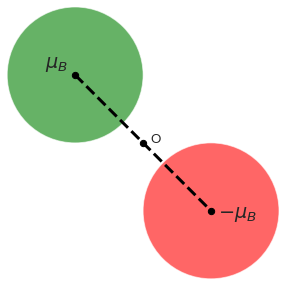

In [56]:
fig, ax = plt.subplots(figsize=(5,5))
c1 = Circle((-1, 1), 1, fc="g", alpha=0.6)
c2 = Circle((1, -1), 1, fc="r", alpha=0.6)
patches = [c1, c2]
for patch in patches:
    ax.add_artist(patch)
ax.plot([-1, 1], [1, -1], c='k', lw=3, ls="dashed")
ax.scatter([0], [0], c='k', s=40)
ax.scatter([-1], [1], c='k', s=40)
ax.scatter([1], [-1], c='k', s=40)
ax.text(0.1, 0, "O", size='small')
ax.text(-1.1, 1.1, r"$\mu_B$", size='large', ha='right')
ax.text(1.1, -1.1, r"$-\mu_B$", size='large', ha='left')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_aspect("equal")
# ax.set_title("Task B", fontsize=16)
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
plt.show()


In [57]:
fig.savefig("figures/taskB.png", bbox_inches='tight')

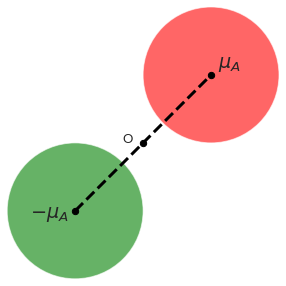

In [62]:
fig, ax = plt.subplots(figsize=(5,5))
c1 = Circle((1, 1), 1, fc="r", alpha=0.6)
c2 = Circle((-1, -1), 1, fc="g", alpha=0.6)
patches = [c1, c2]
for patch in patches:
    ax.add_artist(patch)
ax.plot([-1, 1], [-1, 1], c='k', lw=3, ls="dashed")
ax.scatter([0], [0], c='k', s=40)
ax.scatter([1], [1], c='k', s=40)
ax.scatter([-1], [-1], c='k', s=40)
ax.text(-0.3, 0, "O", size='small')
ax.text(-1.1, -1.1, r"$-\mu_A$", size='large', ha='right')
ax.text(1.1, 1.1, r"$\mu_A$", size='large', ha='left')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_aspect("equal")
# ax.set_title("Task A", fontsize=16)
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
# ax.legend(["Y = 1", "Y = -1"], fontsize=13, frameon=False, loc=2)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [63]:
fig.savefig("figures/taskC.png", bbox_inches='tight')

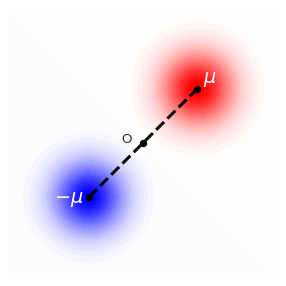

In [38]:
fig, ax = plt.subplots(figsize=(5,5))

sns.set_palette('pastel')

x, y = np.mgrid[-3:3:.1, -3:3:.1]
rv = multivariate_normal([1, 1], 0.20*np.eye(2))
data = np.dstack((x, y))
z1 = rv.pdf(data)
rv = multivariate_normal([-1, -1], 0.20*np.eye(2))
data = np.dstack((x, y))
z2 = rv.pdf(data)
z = z1 - z2
ax.contourf(x, y, z, cmap='bwr', levels=100, alpha=1, extend='both')

ax.plot([-1, 1], [-1, 1], c='k', lw=3, ls="dashed")
ax.scatter([0], [0], c='k', s=40)
ax.scatter([1], [1], c='k', s=40)
ax.scatter([-1], [-1], c='k', s=40)
ax.text(-0.4, 0, "O", size='small')
ax.text(-1.1, -1.1, r"$-\mu$", size='large', ha='right', color='white')
ax.text(1.1, 1.1, r"$\mu$", size='large', ha='left', color='white')
ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-2.5, 2.5])
ax.set_aspect("equal")
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [39]:
fig.savefig("figures/taskA.png", bbox_inches='tight')

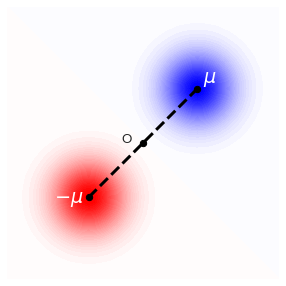

In [40]:
fig, ax = plt.subplots(figsize=(5,5))

sns.set_palette('pastel')

x, y = np.mgrid[-3:3:.1, -3:3:.1]
rv = multivariate_normal([-1, -1], 0.20*np.eye(2))
data = np.dstack((x, y))
z1 = rv.pdf(data)
rv = multivariate_normal([1, 1], 0.20*np.eye(2))
data = np.dstack((x, y))
z2 = rv.pdf(data)
z = z1 - z2
ax.contourf(x, y, z, cmap='bwr', levels=100, alpha=1, extend='both')

ax.plot([-1, 1], [-1, 1], c='k', lw=3, ls="dashed")
ax.scatter([0], [0], c='k', s=40)
ax.scatter([1], [1], c='k', s=40)
ax.scatter([-1], [-1], c='k', s=40)
ax.text(-0.4, 0, "O", size='small')
ax.text(-1.1, -1.1, r"$-\mu$", size='large', ha='right', color='white')
ax.text(1.1, 1.1, r"$\mu$", size='large', ha='left', color='white')
ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-2.5, 2.5])
ax.set_aspect("equal")
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [41]:
fig.savefig("figures/taskB.png", bbox_inches='tight')